# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Ames Housing dataset.

## Objectives

You will be able to:
- Implement interaction terms in Python using the `sklearn` and `statsmodels` packages 
- Interpret interaction variables in the context of a real-world problem 

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below: 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# __SOLUTION__ 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [ ]:
regression = LinearRegression()

In [2]:
# __SOLUTION__ 
regression = LinearRegression()

Create a baseline model which includes all the variables we selected from the Ames housing data set to predict the house prices. Then use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [ ]:
ames = pd.read_csv('ames.csv')

continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

## code here

In [3]:
# __SOLUTION__ 
ames = pd.read_csv('ames.csv')

continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

ames_cont = ames[continuous]

# log features
log_names = [f'{column}_log' for column in ames_cont.columns]

ames_log = np.log(ames_cont)
ames_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

ames_log_norm = ames_log.apply(normalize)

# one hot encode categoricals
ames_ohe = pd.get_dummies(ames[categoricals], prefix=categoricals)

preprocessed = pd.concat([ames_log_norm, ames_ohe], axis=1)

X = preprocessed.drop('SalePrice_log', axis=1)
y = preprocessed['SalePrice_log']

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

0.8174620047489951

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 3 interactions which have the biggest effect on our $R^2$, so print out the top 3 combinations.

You will create a `for` loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

Since there are so many different neighbourhoods we will exclude

In [ ]:
from itertools import combinations

In [ ]:
# code to find top interactions by R^2 value here

In [4]:
# __SOLUTION__ 
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
Top 3 interactions: [('LotArea_log', 'Neighborhood_Mitchel', 0.82), ('GrLivArea_log', 'BldgType_Duplex', 0.82), ('GrLivArea_log', 'KitchenQual_TA', 0.82)]


It looks like the top interactions involve the GrLivArea feature so lets add the interaction between GrLivArea and Neighborhood_Mitchel to our model.

We can interpret this feature as the relationship between GrLivArea and SalePrice when the house is in Mitchel or not.

## Visualize the Interaction

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against `SalePrice`. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

In [ ]:
# Visualization code here

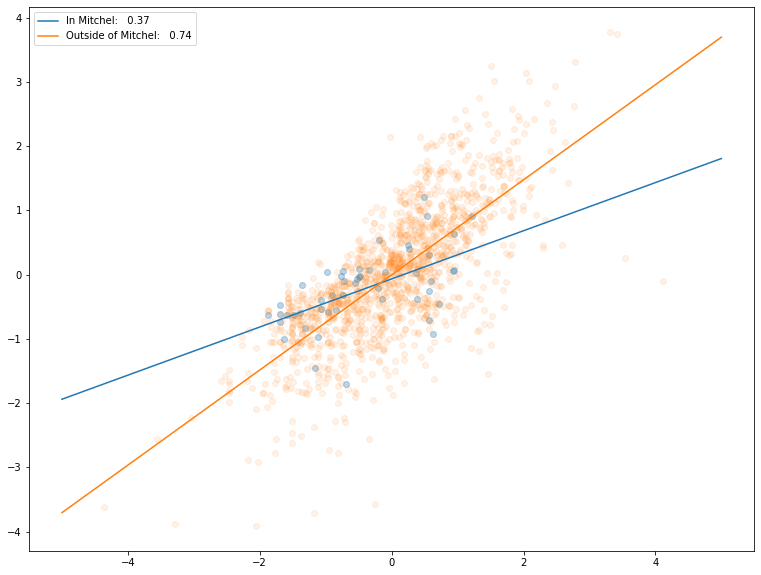

In [5]:
# __SOLUTION__

fig, ax = plt.subplots(figsize=(13, 10))

col = 'GrLivArea_log'

is_in = preprocessed.loc[preprocessed['Neighborhood_Mitchel'] == 1, [col, 'SalePrice_log']]

linreg = LinearRegression()
linreg.fit(is_in[[col]], is_in['SalePrice_log'])

preds = linreg.predict(is_in[[col]])

ax.scatter(is_in[[col]], is_in['SalePrice_log'], alpha=.3, label=None)

x = np.linspace(-5, 5)
ax.plot(x, linreg.predict(x.reshape(-1, 1)), label=f'In Mitchel:   {linreg.coef_[0]:.2f}')

not_in = preprocessed.loc[preprocessed['Neighborhood_Mitchel'] == 0, [col, 'SalePrice_log']]

linreg = LinearRegression()
linreg.fit(not_in[[col]], not_in['SalePrice_log'])

preds = linreg.predict(not_in[[col]])

ax.scatter(not_in[[col]], not_in['SalePrice_log'], alpha=.1, label=None)

x = np.linspace(-5, 5)
ax.plot(x, linreg.predict(x.reshape(-1, 1)), label=f'Outside of Mitchel:   {linreg.coef_[0]:.2f}')

ax.legend()

## Build a final model with interactions

Use 10-fold cross-validation to build a model using the above interaction. 

In [ ]:
# code here

In [6]:
# __SOLUTION__ 
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()

final['Neighborhood_Mitchel*GrLivArea'] = final['Neighborhood_Mitchel'] * final['GrLivArea_log']

final_model = np.mean(cross_val_score(regression, final, y, scoring='r2', cv=crossvalidation))

final_model

0.8174960819363731

Our $R^2$ has not increased considerably. Let's have a look in `statsmodels` to see if these interactions are significant.

In [ ]:
# code here

In [7]:
# __SOLUTION__ 
import statsmodels.api as sm
df_inter_sm = sm.add_constant(final)
model = sm.OLS(y,final)
results = model.fit()

results.summary()

/Users/pisel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/pisel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/pisel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     153.4
Date:                Tue, 07 Mar 2023   Prob (F-statistic):               0.00
Time:                        08:49:31   Log-Likelihood:                -737.11
No. Observations:                1460   AIC:                             1572.
Df Residuals:                    1411   BIC:                             1831.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
LotArea_log                        0.1039      0.019      5.506      0.000       0.067       0.141
1stFlrSF_log                       0.1378      0.016      8.625      0.000       0.106       0.169
GrLivArea_log                      0.3795      0.016     24.115      0.000       0.349       0.410
BldgType_1Fam                      0.1308      0.037      3.565      0.000       0.059       0.203
BldgType_2fmCon                   -0.0380      0.073     -0.517      0.605      -0.182       0.106
BldgType_Duplex                   -0.2777      0.058     -4.796      0.000      -0.391      -0.164
BldgType_Twnhs                    -0.0067      0.075     -0.089      0.929      -0.154       0.141
BldgType_TwnhsE                    0.0829      0.049      1.688      0.092      -0.013       0.179
KitchenQual_Ex                     0.4844      0.049      9.967      0.000       0.389       0.580
KitchenQual_Fa                    -0.5137      0.060     -8.525      0.000      -0.632      -0.395
KitchenQual_Gd                     0.1049      0.032      3.276      0.001       0.042       0.168
KitchenQual_TA                    -0.1843      0.031     -5.981      0.000      -0.245      -0.124
SaleType_COD                      -0.2035      0.080     -2.559      0.011      -0.359      -0.047
SaleType_CWD                       0.0203      0.191      0.106      0.915      -0.355       0.396
SaleType_Con                       0.3785      0.270      1.400      0.162      -0.152       0.909
SaleType_ConLD                     0.1088      0.137      0.793      0.428      -0.160       0.378
SaleType_ConLI                    -0.1749      0.173     -1.011      0.312      -0.514       0.164
SaleType_ConLw                    -0.1883      0.174     -1.084      0.278      -0.529       0.152
SaleType_New                       0.0935      0.067      1.400      0.162      -0.037       0.224
SaleType_Oth                      -0.1126      0.219     -0.513      0.608      -0.543       0.318
SaleType_WD                       -0.0305      0.056     -0.548      0.584      -0.140       0.079
MSZoning_C (all)                  -0.8295      0.131     -6.321      0.000      -1.087      -0.572
MSZoning_FV                        0.2370      0.097      2.435      0.015       0.046       0.428
MSZoning_RH                        0.0462      0.100      0.463      0.643      -0.149       0.242
MSZoning_RL                        0.1659      0.049      3.402      0.001       0.070       0.262
MSZoning_RM                        0.2718      0.055      4.931      0.000       0.164       0.380
Street_Grvl                        0.0505      0.124      0.407      0.684      -0.193       0.294
Street_Pave                       -0.1592      0.066     -2.398      0.017      -0.289      -0.029
Neighborhood_B

What is your conclusion here?

In [ ]:
# formulate your conclusion

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions can have a strong impact on linear regression models, and they should always be considered when you are constructing your models.